In [ ]:
!nvidia-smi

Sat Apr 15 03:37:30 KST 2023

+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:14:00.0 Off |                    0 |
| N/A   32C    P0    24W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   32

In [27]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import nibabel as nib

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.7.1+cu110
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/aistore3/.conda/envs/snuimageseg/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.8.2+cu110
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.25.1
mlflow version: 2.1.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [11]:
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = "HCC"

In [ ]:
#pip install openpyxl

patient_data = pd.read_excel("tumor_top20.xlsx", usecols="A")
patients = [os.path.join(data_dir, f"{x:07d}.nii.gz") for x in patient_data["patID"]]
print(patients)

In [29]:
def nii_loader(filename) :
    nimg = nib.load(filename)
    return nimg.get_fdata() , nimg.affine, nimg.header

def visualize(dataset, idx=0, target_layer=10):
    import matplotlib.pyplot as plt    

    image = dataset[idx]
    image_data, image_affine, image_header = nii_loader(image)
    
    print('[file path]', image)
    print('[dimension]', image_data.shape)
    target_image = image_data[:,:,target_layer]

    plt.imshow(target_image, cmap='gray')
    plt.show()

[file path] HCC/0085289.nii.gz
[dimension] (320, 320, 100)


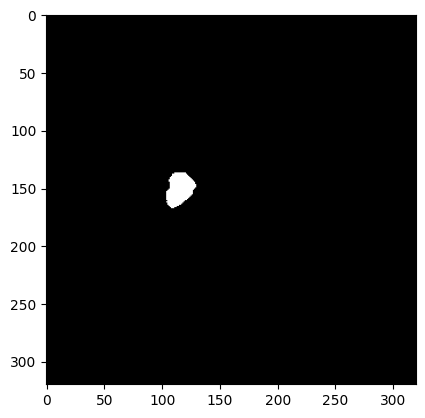

In [134]:
visualize(patients, idx=1,  target_layer=50)

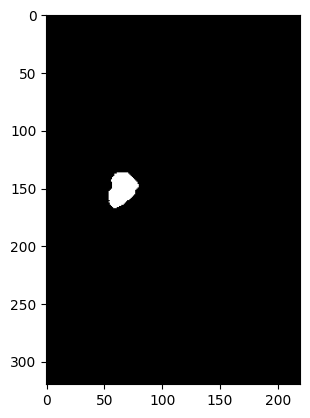

(320, 220)
(array([  0., 255.]), array([69846,   554]))
23.0
30.0


In [138]:
sample2d = nii_loader(patients[1])[0][:,50:-50,50]
plt.imshow(sample2d, cmap='gray')
plt.show()

print(sample2d.shape)
print(np.unique(sample2d, return_counts=True))
print(np.max([np.sum(line)/255 for line in sample2d]))
print(np.max([np.sum(line)/255 for line in sample2d.T]))

In [283]:
def ensure_fit(filename):
    image = nii_loader(filename)[0]
    v_image, h_image, l_image = image.shape
    v_max = h_max = l_count = 0
    
    for i in range(image.shape[2]):
        layer = image[:,:,i]
        v_size = np.max([np.sum(line)/255 for line in layer.T]).astype(int)
        h_size = np.max([np.sum(line)/255 for line in layer]).astype(int)
        if v_size > 0 and h_size > 0:
            l_count += 1
            if v_max < v_size: v_max = v_size
            if h_max < h_size: h_max = h_size
            
    return v_max, h_max, l_count, v_image, h_image, l_image

In [284]:
for patient in patients:
    print(os.path.basename(patient).split('.')[0], *ensure_fit(patient))

0085263 72 84 17 672 672 70
0085289 43 37 22 320 320 100
0085346 36 34 20 320 320 100
0099654 39 37 22 320 320 100
0099993 47 46 27 320 320 100
0100059 18 30 20 320 320 100
0100140 52 43 24 384 300 104
0085313 36 40 18 320 320 100
0085324 29 37 22 320 320 100
0099769 38 38 23 320 320 100
0085265 40 43 19 352 352 100
0085268 38 32 14 352 352 100
0099660 41 36 15 320 320 99
0099672 52 42 16 384 300 104
0099717 36 36 15 320 320 100
0099768 29 34 19 320 320 100
0099786 42 44 21 480 480 105
0100003 32 29 21 320 320 100
0100035 40 46 22 352 352 100
0100048 56 59 21 512 512 92


In [285]:
all_patients = sorted(glob.glob(os.path.join(data_dir, "*.nii.gz")))
results = np.asarray([ensure_fit(patient) for patient in all_patients])

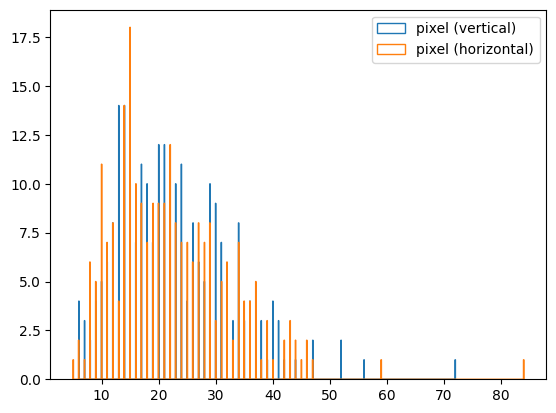

In [291]:
plt.hist(results[:, 0], bins=1000, histtype='step', label="pixel (vertical)")
plt.hist(results[:, 1], bins=1000, histtype='step', label="pixel (horizontal)")
plt.legend()
plt.show()

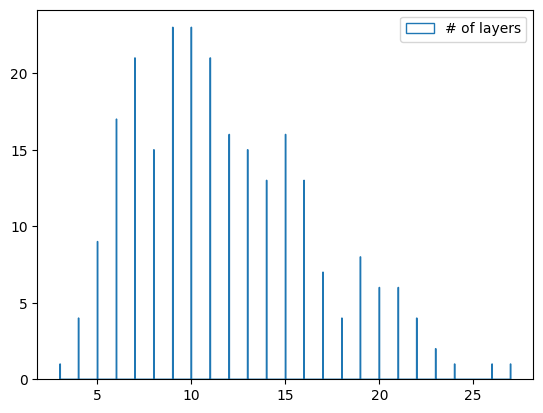

In [295]:
plt.hist(results[:, [2]], bins=1000, histtype='step', label="# of layers")
plt.legend()
plt.show()

In [269]:
indexed = np.concatenate((np.arange(len(results)).reshape(-1,1), results), axis=1)

In [280]:
sorted_results = indexed[(-indexed[:, 1]).argsort()]
for patient in sorted_results[:20]:
    print(os.path.basename(all_patients[patient[0]]).split('.')[0], *patient[1:])

0085263 72 84 17 672 672 70
0100048 56 59 21 512 512 92
0100140 52 43 24 384 300 104
0099672 52 42 16 384 300 104
0099993 47 46 27 320 320 100
0099689 47 47 11 672 672 70
0099791 44 44 15 512 512 100
0085289 43 37 22 320 320 100
0099786 42 44 21 480 480 105
0099694 41 39 14 480 480 100
0099660 41 36 15 320 320 99
0099790 41 36 19 352 352 100
0099674 40 36 11 512 512 100
0099865 40 45 26 320 320 100
0100035 40 46 22 352 352 100
0085265 40 43 19 352 352 100
0099654 39 37 22 320 320 100
0099769 38 38 23 320 320 100
0088192 38 37 12 480 480 100
0085268 38 32 14 352 352 100


In [296]:
results = np.delete(results, np.argmax(results[:, 0]),axis=0)

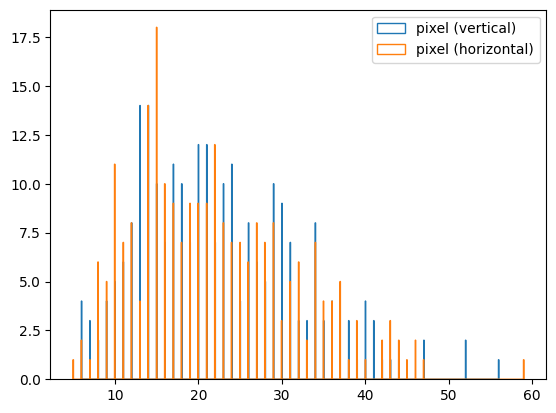

In [297]:
plt.hist(results[:, 0], bins=1000, histtype='step', label="pixel (vertical)")
plt.hist(results[:, 1], bins=1000, histtype='step', label="pixel (horizontal)")
plt.legend()
plt.show()

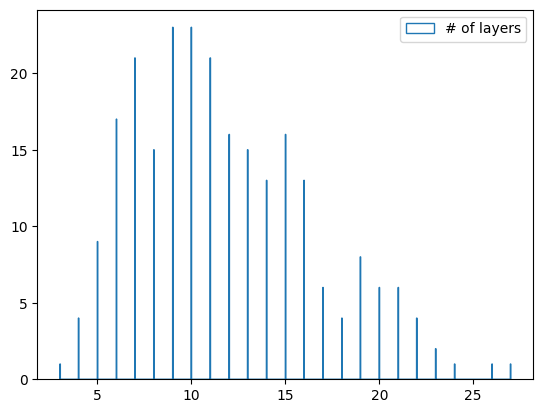

In [298]:
plt.hist(results[:, [2]], bins=1000, histtype='step', label="# of layers")
plt.legend()
plt.show()